Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## All Enforcements by Congressional District

This notebook examines ECHO data using CASE_FACILITIES and CASE_ENFORCEMENTS.
The CASE_NUMBER FIELD links these two tables.  Facilities within the congressional district are identified via the ECHO_EXPORTER data set, with the REGISTRY_ID of ECHO_EXPORTER matched against the same field of CASE_FACILITIES.
HQ_DIVISION identifies the program of the enforcement, and CASE_STATUS_DATE is taken to be the date the enforcement was concluded.


A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [82]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


Run this next cell, select a state, and then run the following cell.

In [83]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state.

In [84]:
my_state = dropdown_state.value

sql = "select REGISTRY_ID, FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, AIR_IDS, FAC_DERIVED_CD113 " + \
    " from ECHO_EXPORTER where AIR_FLAG = 'Y' and FAC_STATE = '" + my_state + "'" 
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
# print(sql)
# print(data_location)


In [85]:
try:
    echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
    echo_data.set_index( "REGISTRY_ID", inplace=True)
except:
    print( "No data for " + my_state )

Run this next cell after choosing a state from the dropdown list.

In [86]:
num_facilities = echo_data.shape[0]
print("There are %s facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 12464 facilities in NY tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.
Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

In [87]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…



Run this next cell after choosing a congressional district from the dropdown list.

In [88]:
my_cd = w2.value
my_cd_facs = echo_data[echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s ICIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 400 ICIS facilities in NY district 1 tracked in the ECHO database.


Next look up the violation history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [95]:
sql = "select cf.REGISTRY_ID, cf.CASE_NUMBER, ce.FISCAL_YEAR, ce.HQ_DIVISION, ce.TOTAL_PENALTY_ASSESSED_AMT " + \
    " from CASE_FACILITIES cf, CASE_ENFORCEMENTS ce where cf.CASE_NUMBER = ce.CASE_NUMBER " + \
    " and cf.STATE_CODE = '" + my_state + "'"

url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)

select cf.REGISTRY_ID, cf.CASE_NUMBER, ce.FISCAL_YEAR, ce.HQ_DIVISION, ce.TOTAL_PENALTY_ASSESSED_AMT  from CASE_FACILITIES cf, CASE_ENFORCEMENTS ce where cf.CASE_NUMBER = ce.CASE_NUMBER  and cf.STATE_CODE = 'NY'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20cf.REGISTRY_ID%2C%20cf.CASE_NUMBER%2C%20ce.FISCAL_YEAR%2C%20ce.HQ_DIVISION%2C%20ce.TOTAL_PENALTY_ASSESSED_AMT%20%20from%20CASE_FACILITIES%20cf%2C%20CASE_ENFORCEMENTS%20ce%20where%20cf.CASE_NUMBER%20%3D%20ce.CASE_NUMBER%20%20and%20cf.STATE_CODE%20%3D%20%27NY%27


In [89]:
sql = "select cf.REGISTRY_ID, cf.CASE_NUMBER, ce.FISCAL_YEAR, ce.HQ_DIVISION, ce.TOTAL_PENALTY_ASSESSED_AMT " + \
    " from CASE_FACILITIES cf, CASE_ENFORCEMENTS ce where cf.CASE_NUMBER = ce.CASE_NUMBER " + \
    " and cf.STATE_CODE = '" + my_state + "'"

url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

case_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
case_data.set_index( "REGISTRY_ID", inplace=True)



There are 13 facilities with 116 EPA enforcements in the district.
There are 820 facilities with 2256 EPA enforcements in the state.


In [112]:
case_fac_data = pd.merge( my_cd_facs, case_data, on='REGISTRY_ID' ).fillna( value={'HQ_DIVISION': 'Unknown'} )
case_facs = case_fac_data[['FAC_NAME', 'FAC_LAT', 'FAC_LONG']].drop_duplicates()
state_case_fac_data = pd.merge( echo_data, case_data, on='REGISTRY_ID' ).fillna( value={'HQ_DIVISION': 'Unknown'} )
state_case_facs = state_case_fac_data[['FAC_NAME', 'FAC_LAT', 'FAC_LONG']].drop_duplicates()

print( "There are %s facilities with %s EPA enforcements in the district." %(len(case_facs), len(case_fac_data)))
print( "There are %s facilities with %s EPA enforcements in the state." %(len(state_case_facs), len(state_case_fac_data)))


There are 13 facilities with 116 EPA enforcements in the district.
There are 820 facilities with 2256 EPA enforcements in the state.


Save the data to a CSV file in your Google Drive.
The first of the next three cells will open our Google Drive to write into.
The second cell writes the congressional district file.
The third cell writes the file for state data.
Running these cells is optional.

In [118]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

Write the congressional district data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/cd_cases-' + my_state + '-' + str( my_cd ) + '.csv'
case_fac_data.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

In [ ]:
Write the state data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/state_cases-' + my_state + '.csv'
state_case_fac_data.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

Map the facilities that have had these enforcement actions.

In [113]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 9
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_my_area = mapper(case_facs)
map_of_facilities_in_my_area

Present another dropdown with the list of names of the facilities.  Choosing a facility will display
the violations.

In [114]:
cd_array = case_fac_data["FAC_NAME"].unique()
cd_array.sort()

w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('ALADDIN PACKAGING LLC', 'AMNEAL PHARMACEUTICALS OF NY', 'BROO…

Run this next cell after choosing a facility.

In [115]:
my_cases = case_fac_data[case_fac_data["FAC_NAME"] == w3.value]
# my_cases[['FAC_NAME', 'FISCAL_YEAR', 'HQ_DIVISION', 'TOTAL_PENALTY_ASSESSED_AMT']]
# my_cases

## Plot the number of enforcements by year and program for the congressional district.

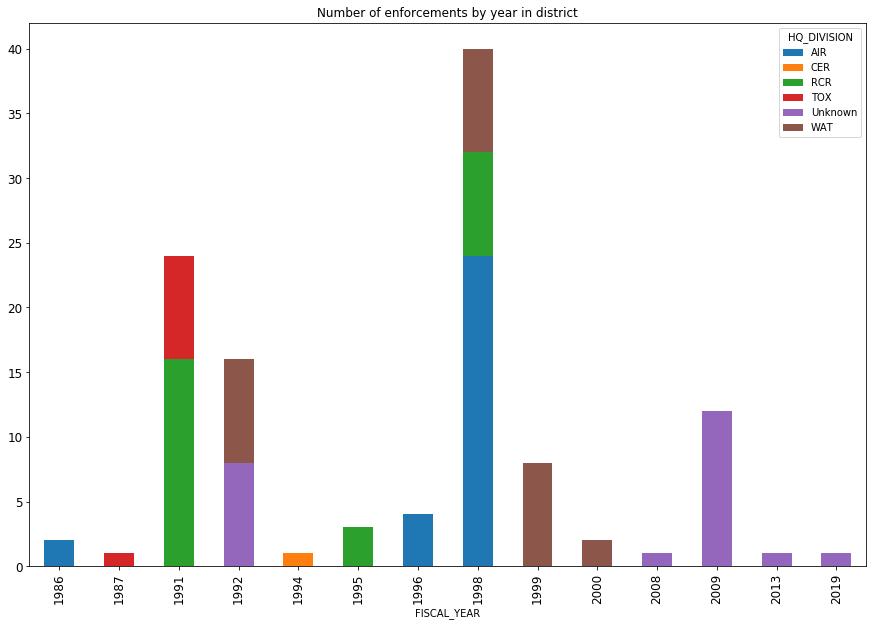

In [116]:
chart_title = 'Number of enforcements by year in district'
case_fac_data.groupby(['FISCAL_YEAR','HQ_DIVISION']).size().unstack().plot(kind='bar', \
                                                                           title = chart_title, figsize=(15, 10), \
                                                                           legend=True, fontsize=12,stacked=True)
plt.show()

## Plot the number of enforcements by year and program for the state.

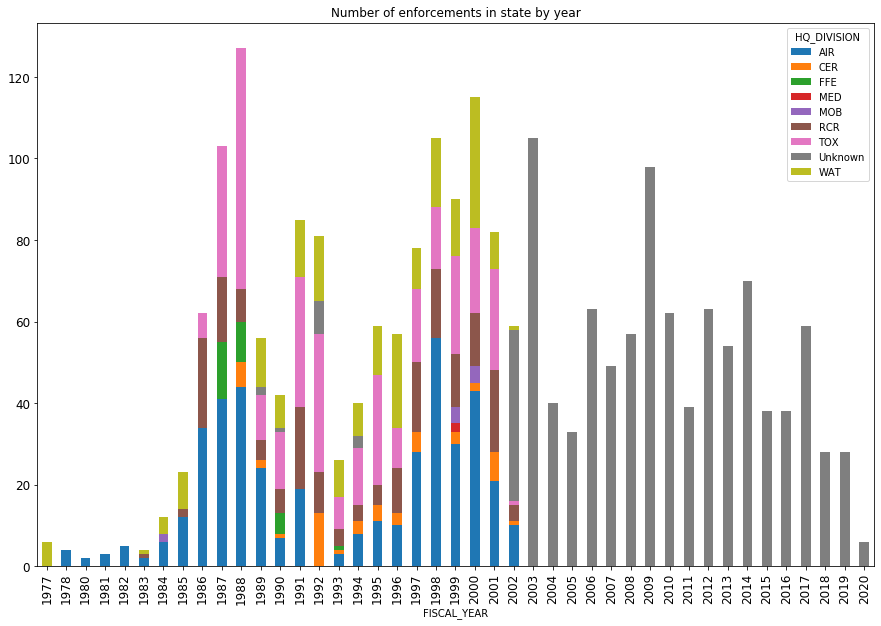

In [117]:
chart_title = 'Number of enforcements in state by year'
state_case_fac_data.groupby(['FISCAL_YEAR','HQ_DIVISION']).size().unstack().plot(kind='bar', \
                                                                           title = chart_title, figsize=(15, 10), \
                                                                           legend=True, fontsize=12,stacked=True)
plt.show()